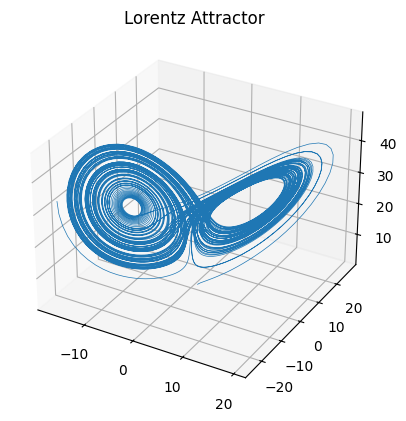

Epoch [10/100], Loss: 0.1834
Epoch [20/100], Loss: 0.0883
Epoch [30/100], Loss: 0.0362
Epoch [40/100], Loss: 0.0249
Epoch [50/100], Loss: 0.0253
Epoch [60/100], Loss: 0.0221
Epoch [70/100], Loss: 0.0200
Epoch [80/100], Loss: 0.0185
Epoch [90/100], Loss: 0.0169
Epoch [100/100], Loss: 0.0154


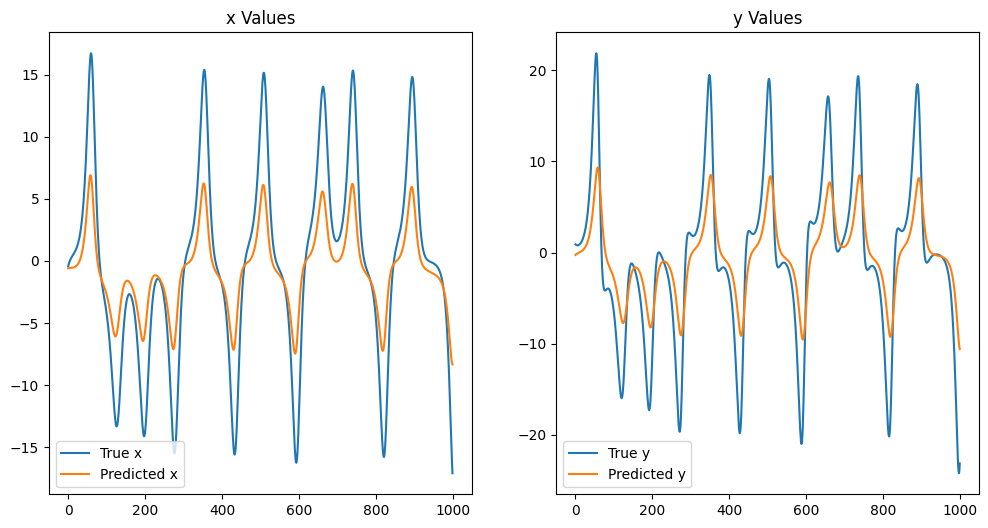

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Lorentz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Lorentz system equations
def lorentz(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial state
initial_state = [1.0, 1.0, 1.0]

# Time vector
t_span = (0, 100)  # integrate for 100 time units
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the system
solution = solve_ivp(lorentz, t_span, initial_state, t_eval=t_eval)

# Extract the states
x, y, z = solution.y

# Plot the attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
plt.title("Lorentz Attractor")
plt.show()

# Prepare data for RNN (x, y, z -> next x, y, z)
data = np.vstack([x, y, z]).T  # Shape: (n_samples, 3)

# Shift data by 1 step to predict the next state
X = data[:-1]  # All except last point (features)
y = data[1:]   # All except first point (target)

# Normalize data (optional, can improve convergence)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Split data into train and test sets
train_size = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

import torch
import torch.nn as nn

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN forward pass
        rnn_out, _ = self.rnn(x)
        # Pass the RNN output through the fully connected layer
        out = self.fc(rnn_out[:, -1, :])  # Take the last RNN output
        return out

# Initialize the model
model = RNNModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Denormalize predictions
predictions_denorm = scaler.inverse_transform(predictions.numpy())
y_test_denorm = scaler.inverse_transform(y_test_tensor.numpy())

# Compare predictions vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test_denorm[:, 0], label='True x')
plt.plot(predictions_denorm[:, 0], label='Predicted x')
plt.legend()
plt.title("x Values")

plt.subplot(1, 2, 2)
plt.plot(y_test_denorm[:, 1], label='True y')
plt.plot(predictions_denorm[:, 1], label='Predicted y')
plt.legend()
plt.title("y Values")

plt.show()


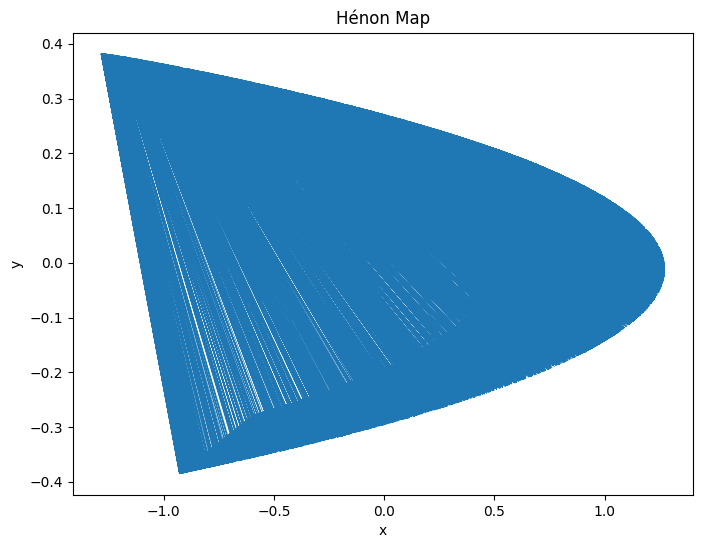

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hénon map parameters
a = 1.4
b = 0.3

# Number of iterations (data points)
n_iter = 10000

# Initialize the system (starting point) - something to iterate?
x_0, y_0 = 0.1, 0.1  # Starting values

# Generate the Hénon map data
x_values = []
y_values = []

x, y = x_0, y_0
for _ in range(n_iter):
    x_values.append(x)
    y_values.append(y)
    x, y = 1 - a * x**2 + y, b * x  # Hénon map equations

# Convert to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)

# Plot the Hénon attractor
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, lw=0.5)
plt.title("Hénon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Prepare data for RNN (x_n, y_n -> x_{n+1}, y_{n+1})
data = np.vstack([x_values, y_values]).T  # Shape: (n_samples, 2)

# Shift data by 1 step to predict the next state
X = data[:-1]  # All except last point (features)
y = data[1:]   # All except first point (target)

# Normalize data (optional, can improve convergence)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Split data into train and test sets
train_size = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

import torch
import torch.nn as nn

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN forward pass
        rnn_out, _ = self.rnn(x)
        # Pass the RNN output through the fully connected layer
        out = self.fc(rnn_out[:, -1, :])  # Take the last RNN output
        return out

# Initialize the model
model = RNNModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Denormalize predictions
predictions_denorm = scaler.inverse_transform(predictions.numpy())
y_test_denorm = scaler.inverse_transform(y_test_tensor.numpy())

# Compare predictions vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test_denorm[:, 0], label='True x')
plt.plot(predictions_denorm[:, 0], label='Predicted x')
plt.legend()
plt.title("x Values")

plt.subplot(1, 2, 2)
plt.plot(y_test_denorm[:, 1], label='True y')
plt.plot(predictions_denorm[:, 1], label='Predicted y')
plt.legend()
plt.title("y Values")

plt.show()


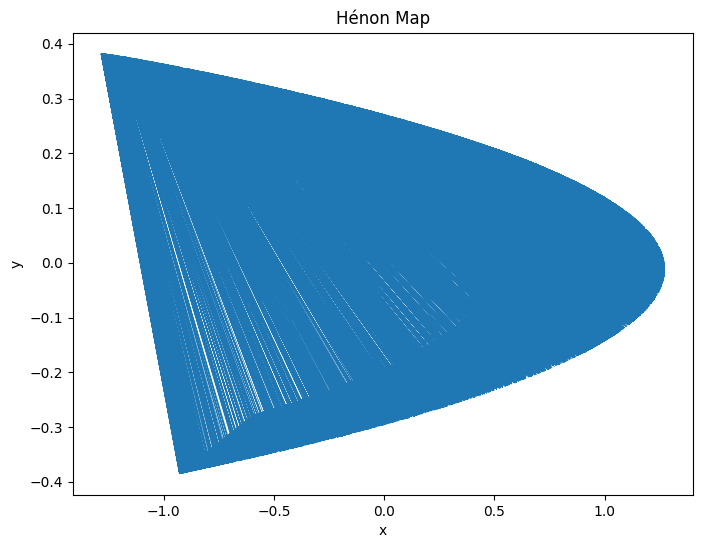

Lyapunov Exponent: 13.3294717088696


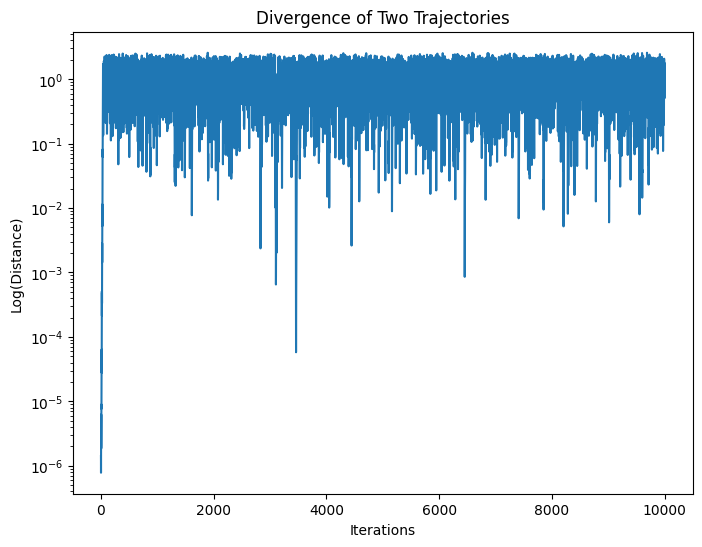

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hénon map parameters
a = 1.4
b = 0.3

# Number of iterations (data points)
n_iter = 10000

# Initialize the system (starting point)
x_0, y_0 = 0.1, 0.1  # Starting values

# Generate the Hénon map data
x_values = []
y_values = []

x, y = x_0, y_0
for _ in range(n_iter):
    x_values.append(x)
    y_values.append(y)
    x, y = 1 - a * x**2 + y, b * x  # Hénon map equations

# Convert to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)

# Plot the Hénon attractor
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, lw=0.5)
plt.title("Hénon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Calculate Lyapunov Exponent for the Hénon map

def lyapunov_exponent(x0, y0, a=1.4, b=0.3, n_iter=10000, epsilon=1e-6):
    # Initially perturb the trajectory
    x, y = x0, y0
    x_perturbed, y_perturbed = x0 + epsilon, y0 + epsilon  # Perturbation

    # Track the divergence between the two trajectories
    divergence = 0

    for _ in range(n_iter):
        # Compute the difference between the two trajectories
        dx = x_perturbed - x
        dy = y_perturbed - y
        distance = np.sqrt(dx**2 + dy**2)

        # Update the divergence estimate (logarithmic divergence)
        divergence += np.log(distance / epsilon)

        # Evolve the system with the Hénon map equations
        x, y = 1 - a * x**2 + y, b * x
        x_perturbed, y_perturbed = 1 - a * x_perturbed**2 + y_perturbed, b * x_perturbed

    # Compute the average Lyapunov exponent
    lyapunov = divergence / n_iter
    return lyapunov

# Calculate the Lyapunov exponent
lyapunov_exp = lyapunov_exponent(x0=0.1, y0=0.1, a=a, b=b, n_iter=10000)
print(f"Lyapunov Exponent: {lyapunov_exp}")

# Visualize the Lyapunov Exponent: The value should be positive, indicating chaos
# You can also track how divergence grows for different starting points or over time.

# Optionally, plot the separation of the two trajectories over time to visualize the divergence
def plot_divergence(x0, y0, a=1.4, b=0.3, n_iter=1000, epsilon=1e-6):
    # Initially perturb the trajectory
    x, y = x0, y0
    x_perturbed, y_perturbed = x0 + epsilon, y0 + epsilon  # Perturbation

    distances = []

    for _ in range(n_iter):
        # Compute the difference between the two trajectories
        dx = x_perturbed - x
        dy = y_perturbed - y
        distance = np.sqrt(dx**2 + dy**2)
        distances.append(distance)

        # Evolve the system with the Hénon map equations
        x, y = 1 - a * x**2 + y, b * x
        x_perturbed, y_perturbed = 1 - a * x_perturbed**2 + y_perturbed, b * x_perturbed

    # Plot the divergence of the trajectories over time
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.yscale('log')
    plt.title("Divergence of Two Trajectories")
    plt.xlabel("Iterations")
    plt.ylabel("Log(Distance)")
    plt.show()

# Plot the divergence over time
plot_divergence(x0=0.1, y0=0.1, a=a, b=b, n_iter=10000, epsilon=1e-6)


Epoch [10/100], Loss: 0.1356, Gradient Norm: 0.6393
Epoch [20/100], Loss: 0.0613, Gradient Norm: 0.3936
Epoch [30/100], Loss: 0.0279, Gradient Norm: 0.1309
Epoch [40/100], Loss: 0.0241, Gradient Norm: 0.0926
Epoch [50/100], Loss: 0.0225, Gradient Norm: 0.0992
Epoch [60/100], Loss: 0.0195, Gradient Norm: 0.0461
Epoch [70/100], Loss: 0.0175, Gradient Norm: 0.0335
Epoch [80/100], Loss: 0.0158, Gradient Norm: 0.0346
Epoch [90/100], Loss: 0.0141, Gradient Norm: 0.0293
Epoch [100/100], Loss: 0.0126, Gradient Norm: 0.0280


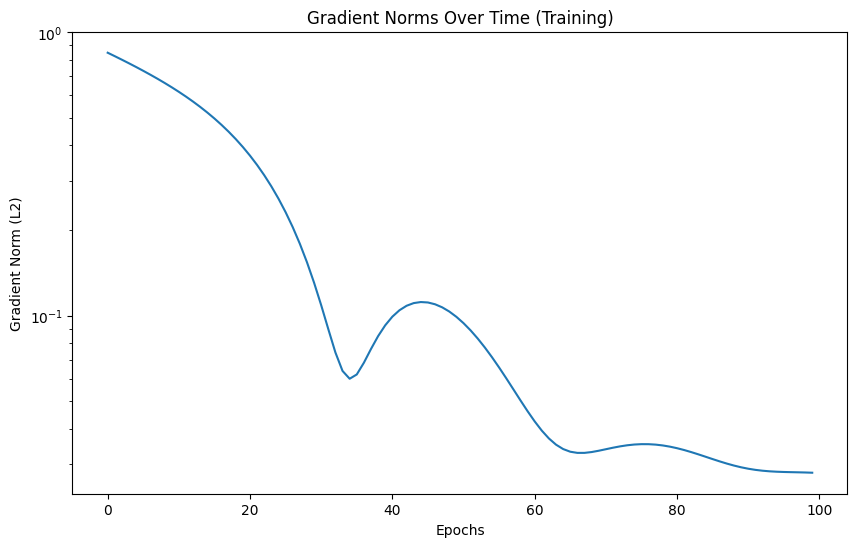

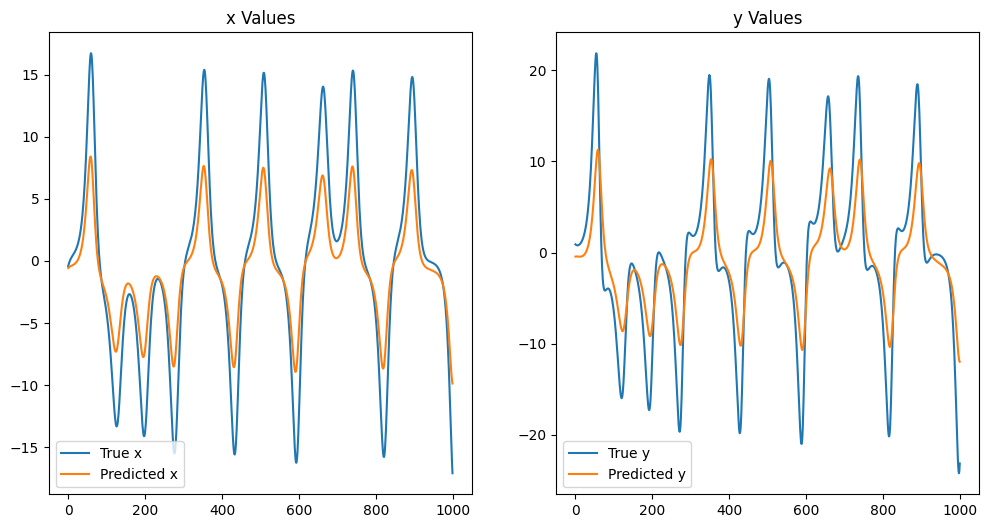

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Lorentz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Lorentz system equations
def lorentz(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial state
initial_state = [1.0, 1.0, 1.0]

# Time vector
t_span = (0, 100)  # integrate for 100 time units
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the system
solution = solve_ivp(lorentz, t_span, initial_state, t_eval=t_eval)

# Extract the states
x, y, z = solution.y

# Prepare data for RNN (x, y, z -> next x, y, z)
data = np.vstack([x, y, z]).T  # Shape: (n_samples, 3)

# Shift data by 1 step to predict the next state
X = data[:-1]  # All except last point (features)
y = data[1:]   # All except first point (target)

# Normalize data (optional, can improve convergence)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Split data into train and test sets
train_size = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN forward pass
        rnn_out, _ = self.rnn(x)
        # Pass the RNN output through the fully connected layer
        out = self.fc(rnn_out[:, -1, :])  # Take the last RNN output
        return out

# Initialize the model
model = RNNModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
epochs = 100
gradient_norms = []  # List to store gradient norms

for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # Calculate gradient norm
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    total_norm = total_norm ** 0.5
    gradient_norms.append(total_norm)

    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Gradient Norm: {total_norm:.4f}")

# Plot gradient norms over time
plt.figure(figsize=(10, 6))
plt.plot(gradient_norms)
plt.title('Gradient Norms Over Time (Training)')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm (L2)')
plt.yscale('log')  # Log scale to better visualize the magnitude
plt.show()

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Denormalize predictions
predictions_denorm = scaler.inverse_transform(predictions.numpy())
y_test_denorm = scaler.inverse_transform(y_test_tensor.numpy())

# Compare predictions vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test_denorm[:, 0], label='True x')
plt.plot(predictions_denorm[:, 0], label='Predicted x')
plt.legend()
plt.title("x Values")

plt.subplot(1, 2, 2)
plt.plot(y_test_denorm[:, 1], label='True y')
plt.plot(predictions_denorm[:, 1], label='Predicted y')
plt.legend()
plt.title("y Values")

plt.show()


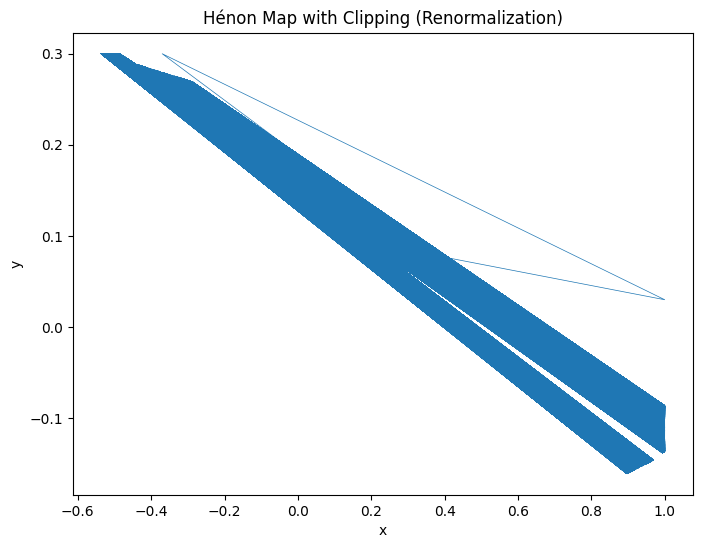

Epoch [10/100], Loss: 0.4052
Epoch [20/100], Loss: 0.2777
Epoch [30/100], Loss: 0.1906
Epoch [40/100], Loss: 0.1383
Epoch [50/100], Loss: 0.1063
Epoch [60/100], Loss: 0.0798
Epoch [70/100], Loss: 0.0558
Epoch [80/100], Loss: 0.0363
Epoch [90/100], Loss: 0.0216
Epoch [100/100], Loss: 0.0117


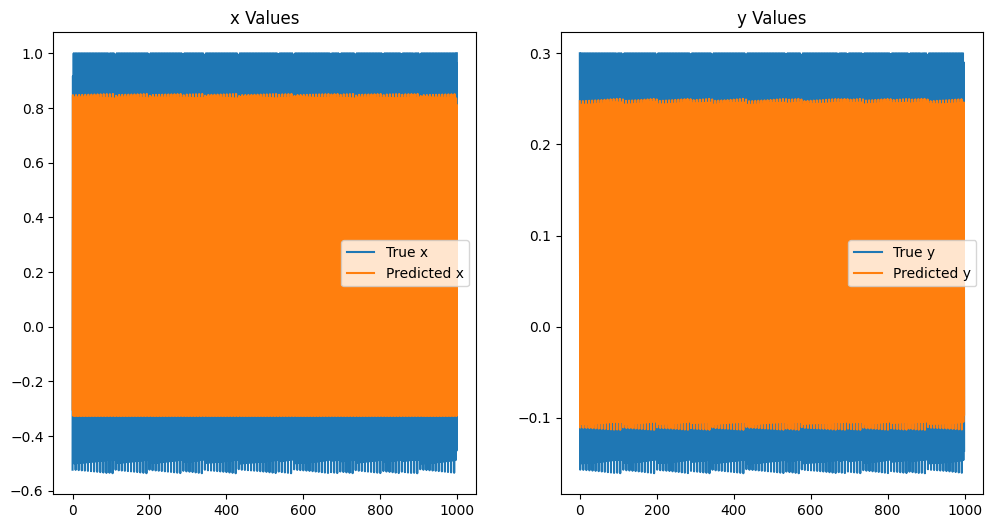

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hénon map parameters
a = 1.4
b = 0.3

# Number of iterations (data points)
n_iter = 10000

# Initialize the system (starting point) - something to iterate?
x_0, y_0 = 0.1, 0.1  # Starting values

# Define clipping bounds for the x and y values
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

# Generate the Hénon map data
x_values = []
y_values = []

x, y = x_0, y_0
for _ in range(n_iter):
    # Append the current values to the list
    x_values.append(x)
    y_values.append(y)

    # Apply the Hénon map equations
    x, y = 1 - a * x**2 + y, b * x

    # Clip the values to stay within the defined compact region
    x = np.clip(x, x_min, x_max)
    y = np.clip(y, y_min, y_max)

# Convert to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)

# Plot the Hénon attractor
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, lw=0.5)
plt.title("Hénon Map with Clipping (Renormalization)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Prepare data for RNN (x_n, y_n -> x_{n+1}, y_{n+1})
data = np.vstack([x_values, y_values]).T  # Shape: (n_samples, 2)

# Shift data by 1 step to predict the next state
X = data[:-1]  # All except last point (features)
y = data[1:]   # All except first point (target)

# Normalize data (optional, can improve convergence)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Split data into train and test sets
train_size = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

import torch
import torch.nn as nn

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN forward pass
        rnn_out, _ = self.rnn(x)
        # Pass the RNN output through the fully connected layer
        out = self.fc(rnn_out[:, -1, :])  # Take the last RNN output
        return out

# Initialize the model
model = RNNModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Denormalize predictions
predictions_denorm = scaler.inverse_transform(predictions.numpy())
y_test_denorm = scaler.inverse_transform(y_test_tensor.numpy())

# Compare predictions vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test_denorm[:, 0], label='True x')
plt.plot(predictions_denorm[:, 0], label='Predicted x')
plt.legend()
plt.title("x Values")

plt.subplot(1, 2, 2)
plt.plot(y_test_denorm[:, 1], label='True y')
plt.plot(predictions_denorm[:, 1], label='Predicted y')
plt.legend()
plt.title("y Values")

plt.show()


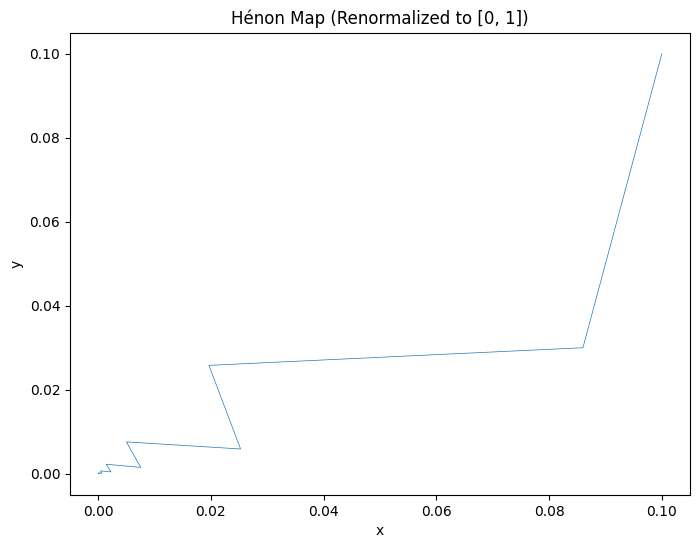

array([[0.086     , 0.03      ],
       [0.0196456 , 0.0258    ],
       [0.02525967, 0.00589368],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hénon map parameters
a = 1.4
b = 0.3

# Number of iterations (data points)
n_iter = 10000

# Initialize the system (starting point) - something to iterate?
x_0, y_0 = 0.1, 0.1  # Starting values

# Define the compact region [0, 1]
def map_to_compact_region(value):
    # Map the value to the range [0, 1] by subtracting the integer part
    return value - np.floor(value)

# Generate the Hénon map data
x_values = []
y_values = []

x, y = x_0, y_0
for _ in range(n_iter):
    # Append the current values to the list
    x_values.append(x)
    y_values.append(y)

    # Apply the Hénon map equations
    x, y = 1 - a * x**2 + y, b * x

    # Map values to the compact region [0, 1]
    x = map_to_compact_region(x)
    y = map_to_compact_region(y)

# Convert to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)

# Plot the Hénon attractor with the new mapping
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, lw=0.5)
plt.title("Hénon Map (Renormalized to [0, 1])")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Prepare data for RNN (x_n, y_n -> x_{n+1}, y_{n+1})
data = np.vstack([x_values, y_values]).T  # Shape: (n_samples, 2)

# Shift data by 1 step to predict the next state
X = data[:-1]  # All except last point (features)
y = data[1:]   # All except first point (target)

# Normalize data (optional, can improve convergence)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Split data into train and test sets
train_size = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y
